# Understanding LIME (Local Interpretable Model-agnostic Explainer)


## References

Original LIME Paper

* ["Why Should I Trust You?" Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf)

Book Chapters

* https://ema.drwhy.ai/LIME.html#ref-imlRPackage
* https://christophm.github.io/interpretable-ml-book/lime.html

Implementations

* Python https://github.com/marcotcr/lime
* R https://github.com/thomasp85/lime

Other references

* https://arxiv.org/pdf/2006.12302.pdf
* https://homes.cs.washington.edu/~marcotcr/blog/lime/
* https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/
* https://cran.r-project.org/web/packages/lime/vignettes/Understanding_lime.html
* https://www.duo.uio.no/bitstream/handle/10852/74988/ideal19Final.pdf?sequence=1




## Visual Intuition behind LIME

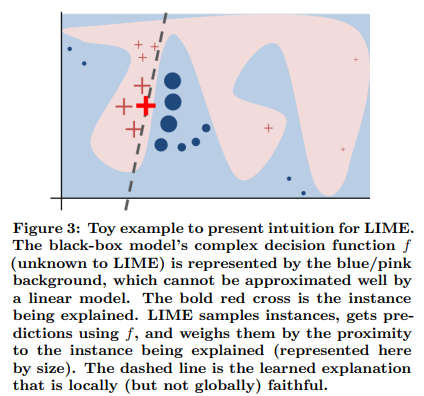

Source: https://arxiv.org/pdf/1602.04938.pdf

---

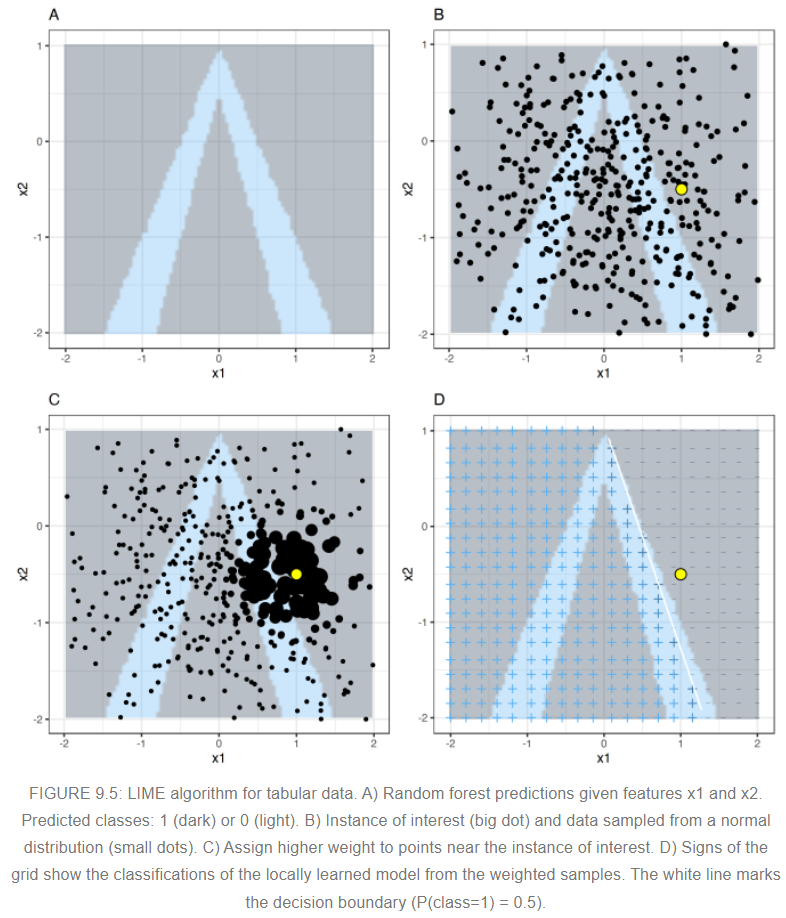

Source: https://christophm.github.io/interpretable-ml-book/lime.html

---

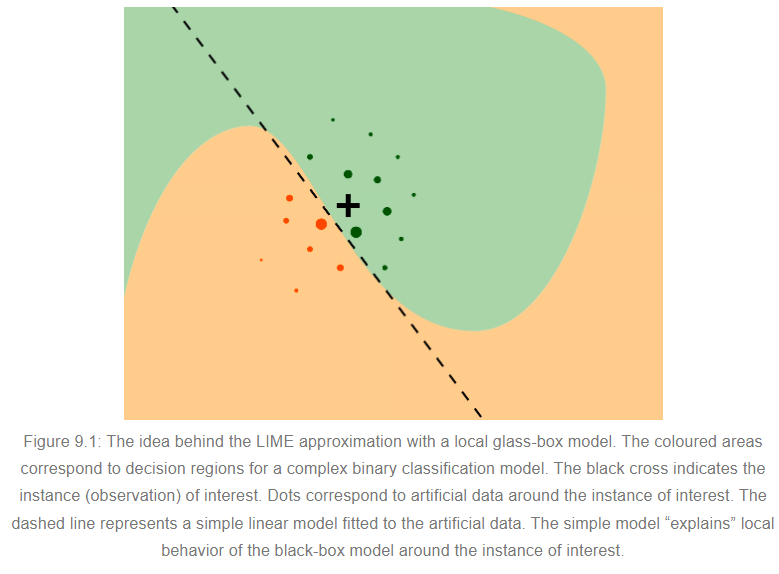

Source: https://ema.drwhy.ai/LIME.html#ref-imlRPackage

# Implementing a simplified LIME from scratch

The implementation works only for the simplest scenario: for tabular datasets containing only numerical features. 

## Step-by-Step

### Setup

* We have a dataset $X \in \mathbb{R}^{N\times d}$ containing $N$ observations of $d$ numerical features, and a corresponding vector of labels $y$ where $y_i\in\{0, 1\}$.
* We trained a black-box model $f()$ that learned to classify observations into class $0$ and class $1$.
* We have an instance $x_i \in \mathbb{R}^d$ with corresponding prediction $f(x_i)$ that we want to explain. We want to know which of the $d$ features influenced the prediction and how.

### Procedure

To explain instance $x_i$, we train an interpretable glass-box classifier $g()$ (e.g. a regression model) that approximates the behavior of the black-box classifier $f()$ in the area near $x_i$ (in the "neighborhood" of $x_i$). How do we build such an imitating glass-box classifier?

* We need to create an artificial dataset that contains observations that are close to $x_i$. We need to cleverly sample observations in the neighborhood of $x_i$. We call the sampled dataset $Z \in \mathbb{R}^{M\times d}$. A sampled observation $z_j \in \mathbb{R}^d$ will be in the same "original" feature space as the to-be-explained observation $x_i$. The number of samples $M$ that we draw can be chosen freely.
* We want our glass-box classifier $g()$ to approximate the behavior of our black-box classifier $f()$ in the neighborhood of $x_i$. We have already sampled observations in the neighborhood of $x_i$ and stored them in dataset $Z$. We need to show our glass-box classifier some reference of how the black-box classifier behaves in the neighborhood of $x_i$, i.e. how it performs on dataset $Z$. In other words, we need to apply our black-box classifier onto dataset $Z$ and compute predictions $f(Z)$. Our glass-box classifier can then be trained on the dataset $Z$ with labels $f(Z)$.
* To get an even better approximation of the black-box classifier's behavior in the neighborhood of $x_i$, we calculate the distances of each observation $z_j \in Z$ to $x_i$. We convert these distances into measures of similarity (e.g., `similarity=1/distance`). These similarities between each pair $(z_j, x_i)$ are passed as a parameter of the `fit()` function to train the glass-box classifier. That is: `glass_box.fit(data=Z, labels=f(Z), weights=similarities)`
* Finished - we have trained an *interpretable* glass-box classifier $g()$ that approximates the behavior of the black-box classifier $f()$ in the near area of $x_i$, which is the observation whose prediction $f(x_i)$ we want to explain.
* We can use the glass-box classifier $g()$ to predict $x_i$, ie compute $g(x_i)$, and can use the model's interpretable parameters to explain which variables affect the prediction and how.

### Extension: Interpretable data spaces

The LIME paper suggests training the glass-box classifier on data that is transformed into a better interpretable vector space.
In our case, this practically means that we discretize all of our continuous features: We take a continuous feature, create bins according to some strategy (e.g. equally sized bins; bins based on quantiles. [Here's a nice graphic](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_strategies.html), and then create dummy variables for each bin, where the value 1 indicates that an observation's feature value falls into that bin. 

Note: Be careful of perfect multicollinearity, which can bias the interpretation of the parameters of an interpretable glass-box model. To avoid perfect multicollinearity, we can create $(k-1)$ dummy variables for a variable that we discretized into $k$ bins.

If we use interpretable data spaces, the procedure changes to the following:

* Given our to-be-explained observation $x_i$, generate samples around the neighborhood of $x_i$ and store them into a sampled dataset $Z \in \mathbb{R}^{M\times d}$ (same as we did before).
* Train a discretizer $d()$ on $X$. The discretizer learns to discretize the continuous features of $X$ into bins.
* Apply the discretizer to the sampled dataset $Z$ to get $Z'=d(Z)$. Note that $Z'$ will have only dummy variables as features.
* Compute $f(Z)$ to get the labels required to train our glass-box classifier
* Train the glass-box classifier $g()$ on dataset $Z'$ with labels $f(Z)$
* Explain how the black-box classifier predicted $x_i$ by first transforming $x_i$ into the interpretable feature space, ie computing $d(x_i)$, and then predicting $g(d(x_i))$ using our imitating glass-box classifier $g()$.

In [4]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Create a dataset with non-linearily separable classes

In [5]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

df = pd.DataFrame(dict(x_1 = X[:, 0], x_2 = X[:, 1], label = y))
df.head()

,x_1,x_2,label
0,1.082675,-0.411871,1
1,1.603296,-0.259731,1
2,0.548018,-0.323025,1
3,0.074189,1.037744,0
4,-0.699176,0.723931,0


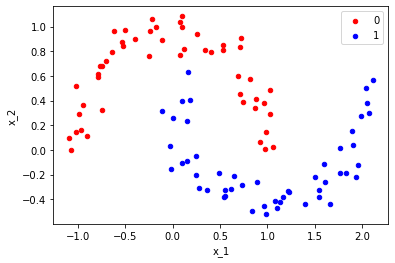

In [6]:
colors = {0: "red", 1: "blue"}
fig, ax = plt.subplots()
grouped = df.groupby("label")
for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x_1", y="x_2", label=key, color=colors[key])
plt.show()

## Build a black box classifier 

Lime can explain individual predictions of any black box classifier. I use a Random Forest Classifier.

In [7]:
from sklearn.ensemble import RandomForestClassifier

blackbox_clf = RandomForestClassifier()
blackbox_clf.fit(X, y)

preds = blackbox_clf.predict(X)
probs = blackbox_clf.predict_proba(X)

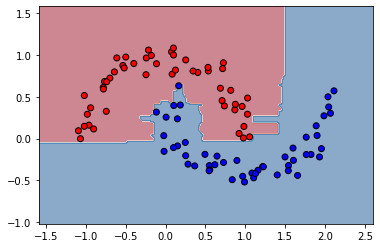

In [8]:
# Plot color-coded decision boundaries

# create mesh grid
step_size = 0.02
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, step_size), np.arange(x2_min, x2_max, step_size))

# predict classes of our grid
predsGrid = blackbox_clf.predict(np.c_[xx.ravel(), yy.ravel()])
predsGrid = predsGrid.reshape(xx.shape)
predsGrid[predsGrid >= 0.5] = 1
predsGrid[predsGrid < 0.5] = 0

from matplotlib.colors import ListedColormap
plt.contourf(xx, yy, predsGrid, cmap=plt.cm.RdBu, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.show()

## Select a single instance which we want to explain

We could just draw a random instance from our dataset $X$. However, I decided to pick an instance that is very close to the decision boundary. Such instance is one where our black box classifier is unsure about whether it belongs to class 0 or class 0.

In [24]:
# Select an instance that is close to the decision boundary, ie Pr(Y=1|x)~0.5
df["pred_label"] = preds
df["pred_proba"] = probs[:, 1]
df["confidence"] = abs(df.pred_proba - 0.5)
i = df.sort_values("confidence", ascending=True).index.tolist()[0]
x = X[i]

print(f"to-be-explained instance i={i}: {x}")

to-be-explained instance i=79: [0.16423287 0.63190887]


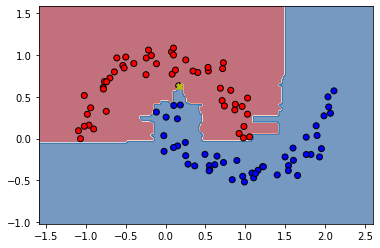

In [25]:
plt.contourf(xx, yy, predsGrid, cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.plot(x[0], x[1], "yX")
plt.show()

## Create samples around the to-be-explained instance x

Sampling observations in the neighborhood is a key part of LIME. There have been several sampling techniques suggested. As this is a tutorial, I decided to use the simplest one, which is also used in the [original LIME implementation](https://github.com/marcotcr/lime).

### Why do we create an artificial dataset when we could sample instances from our dataset?

There could be few observations in our dataset $X$ that are close to the to-be-explained instance $x$. If there are only few observations in $X$ that are in the neighborhood of $x$, then it's not possible to train a glass-box classifier that that approximates the behavior of the black-box classifier in the neighborhood of $x$ well enough.

Our goal is to train a glass-box classifier that approximates the behavior of the black-box classifier in the near neighborhood of the to-be-explained instance $x$. To do this, we need a dataset with many observations that are in the neighborhood of $x$.


In [26]:
def means_and_sdevs(X):
    """Calculates mean and standard deviation for each column of X"""
    means = np.mean(X, axis=0)
    sdevs = np.mean(X, axis=0)
    return means, sdevs

def generate_samples(x, n_samples, sdevs_of_features):
    """
    Generates a dataset of sampled observations close to the 
    to-be-explained instance x.
    """
    n_cols = len(means)
    Z = np.random.normal(0, 1, n_samples*n_cols).reshape(n_samples, n_cols)
    Z = Z * sdevs_of_features + x
    return Z

In [27]:
n_samples = 200
means, sdevs = means_and_sdevs(X)

Z = generate_samples(x, n_samples=n_samples, sdevs_of_features=sdevs)

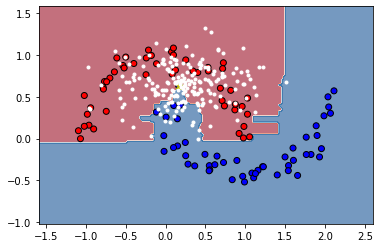

In [28]:
plt.contourf(xx, yy, predsGrid, cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.plot(x[0], x[1], "yX")
plt.plot(Z[:, 0], Z[:, 1], "w.")
plt.show()

## Predict each sampled instance using the black box classifier

In [29]:
preds_samples = blackbox_clf.predict(Z)
preds_samples.shape

(200,)

## Create the dataset on which we train the glass (interpretable) classifier

The interpretable classifier is trained on a discretized dataset. Discretizing continuous variables makes an interpretation easier.

In [30]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=4, encode="onehot", strategy="uniform")
discretizer.fit(X)

X_glass = discretizer.transform(Z)
y_glass = preds_samples

## Calculate distance between each generated sample instance and the to-be-explained instance x

In [31]:
import scipy
def euclidean_dist(X, x):
    print(X.shape)
    print(x.shape)
    distances = scipy.spatial.distance.cdist(
        XA=X,
        XB=x.reshape(1, -1),
        metric="euclidean"
    )
    return distances.reshape(-1)

In [32]:
dists = euclidean_dist(Z, x)
similarities = 1/dists
similarities

(200, 2)
(2,)


array([ 2.06475193,  1.88361556, 30.2318203 ,  1.31990666,  9.77064181,
        1.49903604,  1.37080463, 12.79193214,  6.07277501, 12.56861588,
        3.17129271,  1.96978958,  5.28098162,  2.72409612,  4.98902257,
        2.42595826,  2.53575067,  1.92052364,  3.74496222,  8.71626627,
        2.23229936,  1.0297048 ,  1.05227117,  2.39552002,  7.37061457,
        2.52044545,  2.44156346,  3.50447259,  2.6737221 , 19.31851405,
        1.0852247 ,  4.18187313,  1.61457266,  1.47481616,  6.71996889,
        5.27844295,  1.45936443,  2.74485845,  1.02472639,  1.86445199,
        2.70221686,  3.31184954,  9.85990097, 10.21882506,  2.22794212,
        3.87929745,  1.77891782,  3.3201706 ,  4.72426087,  1.4251302 ,
        3.05200796,  4.5479728 ,  3.29119741,  3.34382402,  1.42683051,
        5.35952434,  5.19752674,  1.40113332,  3.18251201,  4.83314935,
        1.32335657,  4.53744607,  1.51258941,  3.20284112,  1.14307917,
        1.47282471,  2.66342859,  3.00160482,  1.22875383, 18.48

## Train glass (interpretable) classifier

Here, I use logistic regression.

In [85]:
from sklearn.linear_model import LogisticRegression

glass_clf = LogisticRegression()
glass_clf.fit(X_glass, y_glass, sample_weight=similarities)
glass_clf_preds = glass_clf.predict(X_glass)

In [87]:
data_plt = pd.DataFrame(dict(x_1=Z[:, 0], x_2=Z[:, 1], label=y_glass, pred=glass_clf_preds))
data_plt.head()

,x_1,x_2,label,pred
0,0.729029,-0.419497,1,1
1,0.645664,0.088627,1,1
2,0.826025,-0.453257,1,1
3,1.082916,0.224592,0,1
4,0.867565,0.524256,0,0


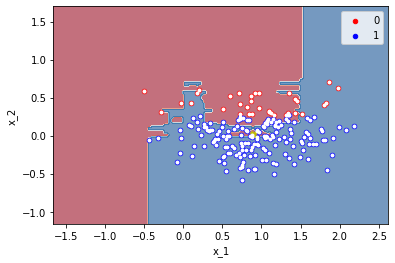

In [88]:
colors = {0: "red", 1: "blue"}
fig, ax = plt.subplots()
ax.contourf(xx, yy, predsGrid, cmap=plt.cm.RdBu, alpha=0.6)
ax.plot(x[0], x[1], "yX")
grouped = data_plt.groupby("pred")
for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x_1", y="x_2", label=key, color=colors[key])
plt.plot(data_plt.x_1, data_plt.x_2, "w.")

The interpretable linear classifier approximates the black box classifier pretty well in the region near our to-be-explained instance $x$ (yellow cross).

## Explain the instance using the interpretable logistic regression model

In [89]:
print(glass_clf.coef_, glass_clf.intercept_)

score = glass_clf.intercept_ + x[0]*glass_clf.coef_[0, 0] + x[1]*glass_clf.coef_[0, 1]
prob = (1/(1+np.exp(-score)))
prob

[[-0.00866493  1.13173138 -1.20053628  0.07726025  2.82696513 -0.12036699
  -2.70680771  0.        ]] [1.53654896]


array([0.8246252])

In [140]:
def pretty_bins(discretizer):
    bin_names = []
    for j, x in enumerate(discretizer.bin_edges_):
        for i in range(1, len(x)-1):
            if i == 1:
                bin_name = f"var_{j}_[-inf, {round(x[i], 3)})"
            elif i < (len(x)-1):
                bin_name = f"var_{j}_[{round(x[i-1], 3)}, {round(x[i], 3)})"
            bin_names.append(bin_name)
            
        bin_name = f"var_{j}_[{round(x[-2], 3)}, +inf)"
        bin_names.append(bin_name)
    return bin_names

In [142]:
pretty_bins(discretizer)

['var_0_[-inf, -0.337)',
 'var_0_[-0.337, 0.485)',
 'var_0_[0.485, 1.306)',
 'var_0_[1.306, +inf)',
 'var_1_[-inf, -0.193)',
 'var_1_[-0.193, 0.274)',
 'var_1_[0.274, 0.74)',
 'var_1_[0.74, +inf)']

In [144]:
glass_clf.coef_[0]
bin_effects = glass_clf.coef_[0]

for bin_name, effect in zip(pretty_bins(discretizer), glass_clf.coef_[0]):
    print(f"{bin_name} \t Effect: {round(effect, 3)}")

var_0_[-inf, -0.337) 	 Effect: -0.009
var_0_[-0.337, 0.485) 	 Effect: 1.132
var_0_[0.485, 1.306) 	 Effect: -1.201
var_0_[1.306, +inf) 	 Effect: 0.077
var_1_[-inf, -0.193) 	 Effect: 2.827
var_1_[-0.193, 0.274) 	 Effect: -0.12
var_1_[0.274, 0.74) 	 Effect: -2.707
var_1_[0.74, +inf) 	 Effect: 0.0


Interpretation: If var ... is in bin ..., then the predicted odds of Y=1 are .... times the odds compared to reference category.